# PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS


In [ ]:
import keras
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Generating reproducible results from same code
tf.random.set_seed(14)

# 1. Data collection and description

In [ ]:
from google.colab import files
uploaded= files.upload()

Saving forestfires.csv to forestfires.csv


In [ ]:
forest= pd.read_csv('forestfires.csv')
forest.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [ ]:
df= forest.copy() # Removing the dummies at this time
df.drop(df.columns[11:30], axis=1, inplace= True)

In [ ]:
df.shape

(517, 12)

In [ ]:
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,small


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [ ]:
df.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'size_category'],
      dtype='object')

In [ ]:
df.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

# 2. Feature Analysis

In [ ]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [ ]:
# The dataset is biased. Lets remove the bias
df.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

# 3. Label encoding

In [ ]:
# We are going to perform label encoding since it is faster than dummy variables

from sklearn import preprocessing
label_encoder= preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month)
df.day= label_encoder.fit_transform(df.day)
df.size_category= label_encoder.fit_transform(df.size_category)
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


# 4. Removing Bias in the Dataset

In [ ]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp= df.copy()
# SMOKET TECHNIQUE

# Define dataset
a= resamp.iloc[:,:-1]
b= resamp.iloc[:,-1]

# Count before
print(Counter(b))

smt= SMOTETomek(sampling_strategy='auto')
a,b= smt.fit_resample(a,b)

# Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 371, 0: 371})


# Train-Test split dataset

In [ ]:
X= a
Y= b
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size= 0.3)

# 5. Neural Network Modeling
## Building the model

In [ ]:
# create model
model= Sequential()
model.add(Dense(14, input_dim= 11, kernel_initializer= 'uniform', activation= 'relu'))
model.add(Dense(12, kernel_initializer= 'uniform', activation= 'relu'))
model.add(Dense(1, kernel_initializer= 'uniform', activation= 'sigmoid'))

# Compile model
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

# Fit the model
hist= model.fit(X_train, y_train, validation_split= 0.33, epochs= 50, batch_size= 10)


Epoch 1/50
35/35 [==============================] - 2s 12ms/step - loss: 0.6920 - accuracy: 0.5101 - val_loss: 0.6886 - val_accuracy: 0.5349
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.6254 - val_loss: 0.6816 - val_accuracy: 0.5465
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6620 - accuracy: 0.6340 - val_loss: 0.6210 - val_accuracy: 0.7035
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.5832 - accuracy: 0.7233 - val_loss: 0.4849 - val_accuracy: 0.7674
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4275 - accuracy: 0.8588 - val_loss: 0.3355 - val_accuracy: 0.8895
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.2984 - accuracy: 0.9193 - val_loss: 0.2268 - val_accuracy: 0.9535
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.2130 - accuracy: 0.9424 - val_loss: 0.2340 - val_accuracy: 0.8779
Epoch 8/50
35/35 [=

# 6. Model Evaluation

In [ ]:
test_loss, test_acc= model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.0470 - accuracy: 0.9776


In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
hist_df= pd.DataFrame(hist.history)
hist_df['epoch']= hist.epoch
hist_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.083135,0.971182,0.041644,0.970930,45
46,0.029246,0.991354,0.026640,0.988372,46
47,0.024990,0.991354,0.021812,0.994186,47
48,0.022987,0.991354,0.026863,0.988372,48
49,0.024946,0.991354,0.023300,0.994186,49


# 7. Visualize Training History

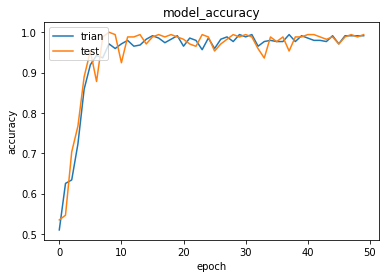

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['trian', 'test'], loc='upper left')
plt.show()

# 8. Tuning of Hyperparameters: Batch Size & Epochs

In [ ]:
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

In [ ]:
# creat model
def create_model():
  model= Sequential()
  model.add(Dense(12, input_dim= 8, kernel_initializer= 'uniform', activation= 'relu'))
  model.add(Dense(8, kernel_initializer= 'uniform', activation= 'relu'))
  model.add(Dense(1, kernel_initializer='uniform', activation= 'sigmoid'))

  adam= Adam(lr= 0.01)
  model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy'])
  return model

In [ ]:
from sklearn.preprocessing import StandardScaler
a= StandardScaler()
a.fit(X)
X_standardized= a.transform(X)

# 9. Tuning of Hyperparameters: Learning rate & Drop out rate 

In [ ]:
from keras.layers import Dropout

# Defining the model
def create_model2(learning_rate, dropout_rate):
  model= Sequential()
  model.add(Dense(14,input_dim= 11, kernel_initializer='uniform', activation= 'relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(12, input_dim= 14, kernel_initializer='uniform', activation= 'relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, kernel_initializer='uniform', activation= 'sigmoid'))

  adam= Adam(lr= learning_rate)
  model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy'])
  return model

# Create the model
model2= KerasClassifier(build_fn= create_model2, verbose= 0, batch_size= 20, epochs= 50)

# Define the grid search parameters
learning_rate= [0.001, 0.01, 0.1]
dropout_rate= [0.0,0.1,0.2]

# Make a dictionary of the grid search parameters
param_grid2= dict(learning_rate= learning_rate, dropout_rate= dropout_rate)

# Build and fit the GridSearchCV
grid2= GridSearchCV(estimator= model2, param_grid= param_grid2, cv= KFold(), verbose= 10)
grid_result2= grid2.fit(X_standardized, Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   5.5s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   4.0s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.966 total time=   5.0s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.959 total time=   6.2s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=1.000 total time=   6.2s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [ ]:
# Summarize the results
print('Best: {}, using {}'.format(grid_result2.best_score_, grid_result2.best_params_))
means2= grid_result2.cv_results_['mean_test_score']
stds2= grid_result2.cv_results_['std_test_score']
params2= grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{}, {} with : {}'.format(mean, stdev,param))
# Best score for Dropout rate= 0.2 and learning rate is 0.001

Best: 0.987837839126587, using {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9824505686759949, 0.016340452117087803 with : {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.979775071144104, 0.016543346645113276 with : {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.832523113489151, 0.2818309726222031 with : {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.985162353515625, 0.015038324160795256 with : {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.970324695110321, 0.012534168962296028 with : {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.8149464845657348, 0.27799699989529414 with : {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.987837839126587, 0.01833062207480573 with : {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9811354875564575, 0.013740447084824511 with : {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.9501632452011108, 0.0426378021641537 with : {'dropout_rate': 0.2, 'learning_rate': 0.1}


# 10. Tuning of Hyperparameters: Activation Function and Kernel Initializer

In [ ]:
# Defining the model
def create_model3(activation_function, init):
  model = Sequential()
  model.add(Dense(14, input_dim= 11, kernel_initializer= init, activation= activation_function))
  model.add(Dropout(0.2))
  model.add(Dense(12, input_dim= 14, kernel_initializer= init, activation= activation_function))
  model.add(Dropout(0.2))
  model.add(Dense(1,activation= 'sigmoid'))

  adam=Adam(lr= 0.001)
  model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy'])
  return model

# Create the model
model3= KerasClassifier(build_fn= create_model3, verbose= 0, batch_size= 20, epochs= 50)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']
# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV
grid3= GridSearchCV(estimator= model3, param_grid= param_grids3, cv= KFold(), verbose= 10)
grid_result3= grid3.fit(X_standardized, Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.000 total time=   7.3s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.685 total time=   6.2s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.480 total time=  11.5s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.595 total time=   7.1s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.108 total time=  11.9s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

# 11. Tuning of Hyperparameter: Number of Neurons in activation layer

In [ ]:
# Defining the model
def create_model4(neuron1, neuron2):
  model= Sequential()
  model.add(Dense(neuron1,input_dim= 11, kernel_initializer='uniform', activation= 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(neuron2, input_dim= neuron1, kernel_initializer='uniform', activation= 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation= 'sigmoid'))

  adam= Adam(lr= 0.001)
  model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy'])
  return model

# Create the model
model4= KerasClassifier(build_fn= create_model4, verbose= 0, batch_size= 20, epochs= 50)

# Define the grid search parameters
neuron1= [4,8,14]
neuron2= [4,8,12]

# Make a dictionary of the grid search parameters
param_grid4= dict(neuron1= neuron1, neuron2= neuron2)

# Build and fit the GridSearchCV
grid4= GridSearchCV(estimator= model4, param_grid= param_grid4, cv= KFold(), verbose= 10)
grid_result4= grid4.fit(X_standardized, Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=4;, score=1.000 total time=   4.7s
[CV 2/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=4;, score=1.000 total time=   6.5s
[CV 3/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.966 total time=   6.2s
[CV 4/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.980 total time=   5.2s
[CV 5/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.797 total time=   6.6s
[CV 1/5; 2/9] START neuron1=4, neuron2=8........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=8;,

In [ ]:
# Summarize the results
print('Best: {}, using {}'.format(grid_result4.best_score_, grid_result4.best_params_))
means4= grid_result4.cv_results_['mean_test_score']
stds4= grid_result4.cv_results_['std_test_score']
params4= grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{}, {} with : {}'.format(mean, stdev,param))
# Best results are Neuron 1= 4 and Neuron 2= 4

Best: 0.9865046143531799, using {'neuron1': 14, 'neuron2': 12}
0.9486486434936523, 0.07675389922308887 with : {'neuron1': 4, 'neuron2': 4}
0.952720844745636, 0.05572864976521378 with : {'neuron1': 4, 'neuron2': 8}
0.9824505567550659, 0.010131983687972019 with : {'neuron1': 4, 'neuron2': 12}
0.9730092525482178, 0.014828215855166188 with : {'neuron1': 8, 'neuron2': 4}
0.9716306805610657, 0.02470479305795718 with : {'neuron1': 8, 'neuron2': 8}
0.9864864826202393, 0.012820049492672759 with : {'neuron1': 8, 'neuron2': 12}
0.9810992121696472, 0.022373253746421136 with : {'neuron1': 14, 'neuron2': 4}
0.9851441979408264, 0.01310745634411565 with : {'neuron1': 14, 'neuron2': 8}
0.9865046143531799, 0.012820100797803073 with : {'neuron1': 14, 'neuron2': 12}


# 12. Hyperparameters all at once
By using two hyperparameters simultaneously, the hyperparameter tuning was completed. We might have overlooked the best values. By determining the optimal values of all the hyperparameters simultaneously provided by the code snippet below, the efficiency can be further enhanced. 

### The expense of computing this procedure is high.

In [ ]:
# Defining the model
def create_model_fnl():
  model= Sequential()
  model.add(Dense(4,input_dim= 11, kernel_initializer='uniform', activation= 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(4, input_dim= 4, kernel_initializer='uniform', activation= 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation= 'sigmoid'))

  adam= Adam(lr= 0.001) # sgd= SGD(lr= learning_rate, momentum= momentum, decay= decay_rate, nesterov= False)
  model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy'])
  return model

# Create the model
model_fnl= KerasClassifier(build_fn= create_model_fnl, verbose= 0, batch_size= 20, epochs= 50)

# Making training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1= train_test_split(X_standardized, Y, test_size= 0.3)

# Fitting the model
hist2= model_fnl.fit(X_train_1, y_train_1)

In [ ]:
pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def report_model(model):
  model_preds= model.predict(X_test_1)
  print(confusion_matrix(y_test_1, model_preds))
  print(classification_report(y_test_1, model_preds))
report_model(model_fnl)

7/7 [==============================] - 0s 4ms/step
[[120   6]
 [  0  97]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       126
           1       0.94      1.00      0.97        97

    accuracy                           0.97       223
   macro avg       0.97      0.98      0.97       223
weighted avg       0.97      0.97      0.97       223

